<a href="https://colab.research.google.com/github/ShreyaSinha59/AWS-Email-Spam-Detector/blob/master/Autoencoders3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from scipy.stats import skew, zscore

In [2]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ============================================================
# 0. IMPORTS
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from collections import Counter
import pickle
import json

import tensorflow as tf
from tensorflow.keras import layers, models

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ============================================================
# 1. LOAD DATA
# ============================================================
# Adjust paths as needed for your environment / Colab
customers = pd.read_csv("/content/drive/MyDrive/FAR-Trans/customer_information.csv")
assets = pd.read_csv("/content/drive/MyDrive/FAR-Trans/asset_information.csv")
close_prices = pd.read_csv("/content/drive/MyDrive/FAR-Trans/close_prices.csv")
transactions = pd.read_csv("/content/drive/MyDrive/FAR-Trans/transactions.csv")

print("Transactions:", transactions.shape)
print("Customers:", customers.shape)
print("Assets:", assets.shape)
print("Close prices:", close_prices.shape)

Transactions: (388048, 9)
Customers: (32468, 6)
Assets: (836, 9)
Close prices: (703303, 3)



Transactions head:
             customerID          ISIN  transactionID transactionType  \
0  00017496858921195E5A  GRS434003000        7590224             Buy   
1  00017496858921195E5A  GRS434003000        7607029            Sell   
2  00017496858921195E5A  GRS434003000        7634872             Buy   
3  00017496858921195E5A  GRS434003000        7652627            Sell   
4  00017496858921195E5A  GRS434003000        7664807             Buy   

    timestamp  totalValue   units           channel marketID  
0  2020-03-27     11000.0  5000.0  Internet Banking     XATH  
1  2020-04-06     12080.0  5000.0  Internet Banking     XATH  
2  2020-04-24     13400.0  5000.0  Internet Banking     XATH  
3  2020-05-07     12700.0  5000.0  Internet Banking     XATH  
4  2020-05-15     12150.0  5000.0  Internet Banking     XATH  

Transactions missing values:
customerID         0
ISIN               0
transactionID      0
transactionType    0
timestamp          0
totalValue         0
units        

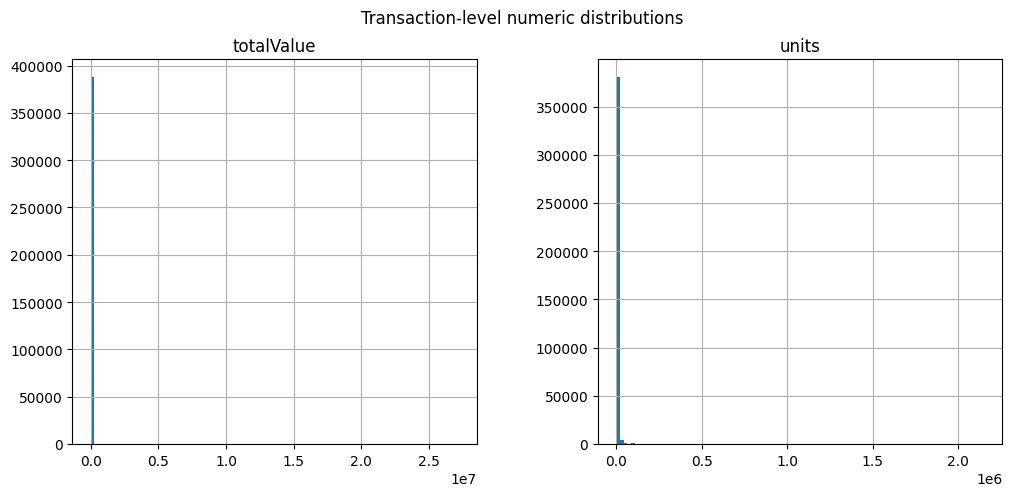

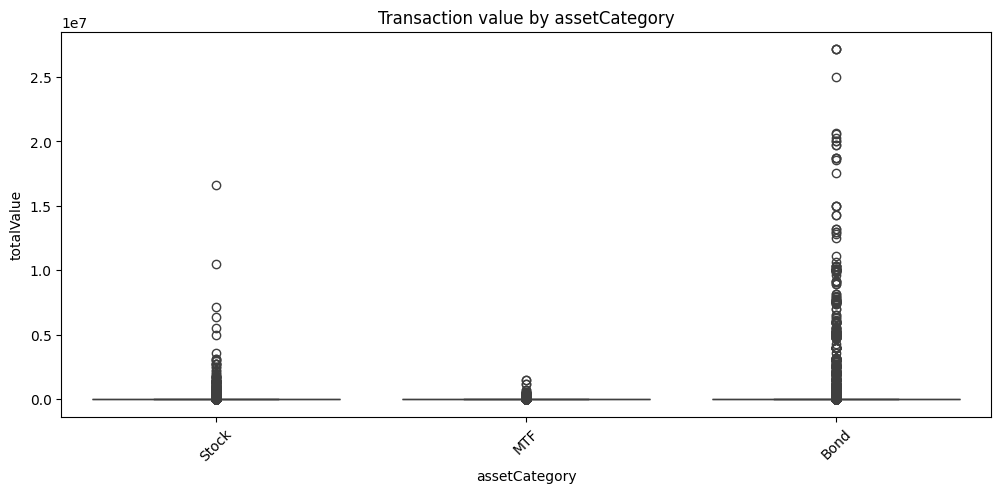

In [4]:
# ============================================================
# 2. BASIC EDA
# ============================================================
print("\nTransactions head:")
print(transactions.head())

print("\nTransactions missing values:")
print(transactions.isna().sum())

# Simple numeric distributions
num_cols_tx = ["totalValue", "units"]
transactions[num_cols_tx].hist(bins=100, figsize=(12, 5))
plt.suptitle("Transaction-level numeric distributions")
plt.show()

# Transaction value by assetCategory (using assets)
tx_assets = transactions.merge(assets[["ISIN", "assetCategory"]], on="ISIN", how="left")
plt.figure(figsize=(12, 5))
sns.boxplot(data=tx_assets, x="assetCategory", y="totalValue")
plt.xticks(rotation=45)
plt.title("Transaction value by assetCategory")
plt.show()


In [5]:
# ============================================================
# 2. MERGE DATASETS (with timestamp fixing)
# ============================================================

# Standardize column names
if "closePrice" in close_prices.columns:
    close_prices = close_prices.rename(columns={"closePrice": "close_price"})

# Convert timestamps
transactions["timestamp"] = pd.to_datetime(transactions["timestamp"], errors="coerce")
close_prices["timestamp"] = pd.to_datetime(close_prices["timestamp"], errors="coerce")

# Detect if close_prices has time component
tx_has_time = transactions["timestamp"].dt.time.nunique() > 1
cp_has_time = close_prices["timestamp"].dt.time.nunique() > 1

# Match granularity
if tx_has_time and cp_has_time:
    df = transactions.merge(
        close_prices[["ISIN", "timestamp", "close_price"]],
        on=["ISIN", "timestamp"],
        how="left"
    )
else:
    transactions["date"] = transactions["timestamp"].dt.date
    close_prices["date"] = close_prices["timestamp"].dt.date
    df = transactions.merge(
        close_prices[["ISIN", "date", "close_price"]],
        on=["ISIN", "date"],
        how="left"
    )

# Merge customer + asset info
df = df.merge(customers, on="customerID", how="left") \
       .merge(assets, on="ISIN", how="left")

# ============================================================
# 3. FEATURE ENGINEERING (REQUIRED BEFORE EDA)
# ============================================================

df["unit_price"] = df["totalValue"] / df["units"].replace(0, np.nan)

cap_map = {
    "CAP_LT_30K": 15000,
    "CAP_30K_80K": 55000,
    "CAP_80K_300K": 190000,
    "CAP_GT300K": 350000,
    "Not_Available": np.nan
}
df["capacity_numeric"] = df["investmentCapacity"].map(cap_map)#helps to identify
## this is required to convert them into numerical columns instead of categroiical
## it explains investment capacity of the customer

df["value_pct_of_capacity"] = df["totalValue"] / (df["capacity_numeric"] + 1e-6)
##value_pct_of_capacity = totalValue / capacity_numeric

cust_baseline = df.groupby("customerID")["totalValue"].agg(
    cust_mean_value="mean",
    cust_std_value="std"
).reset_index()
df = df.merge(cust_baseline, on="customerID", how="left")
##These give a baseline on how the customer usually trades.

df["value_dev_from_cust"] = (df["totalValue"] - df["cust_mean_value"]) / (df["cust_std_value"] + 1e-6)
##How unusual this trade is relative to the customer's history.

# Asset category shift
cust_main_cat = df.groupby(["customerID","assetCategory"]).size().reset_index(name="cnt")
cust_main_cat = cust_main_cat.sort_values(["customerID","cnt"], ascending=[True,False])
cust_main_cat = cust_main_cat.drop_duplicates("customerID")[["customerID","assetCategory"]]
cust_main_cat = cust_main_cat.rename(columns={"assetCategory":"main_assetCategory"})
#Identifies the customer’s dominant trading segment.

df = df.merge(cust_main_cat, on="customerID", how="left")
df["is_new_assetCategory_for_cust"] = (df["assetCategory"] != df["main_assetCategory"]).astype(int)

# Price deviation features
df["close_price"] = df["close_price"].fillna(method="ffill").fillna(method="bfill")
## Daily market closing price for the traded instrument.

df["price_deviation"] = df["unit_price"] - df["close_price"]
df["price_deviation_pct"] = df["price_deviation"] / (df["close_price"] + 1e-6)
df["log_return_tx"] = np.log((df["unit_price"] + 1e-6) / (df["close_price"] + 1e-6))

# Volatility features
asset_vol = close_prices.groupby("ISIN")["close_price"].std().reset_index()
asset_vol = asset_vol.rename(columns={"close_price": "asset_volatility"})
df = df.merge(asset_vol, on="ISIN", how="left")

df["price_volatility_normalized"] = df["price_deviation"] / (df["asset_volatility"] + 1e-6)


/tmp/ipython-input-3148491279.py:78: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["close_price"] = df["close_price"].fillna(method="ffill").fillna(method="bfill")



=== DATASET SUMMARY ===
                  customerID          ISIN  transactionID transactionType  \
count                 639535        639535   6.395350e+05          639535   
unique                 29090           320            NaN               2   
top     A77DFF56D3A2D0E21E22  GRS003003035            NaN             Buy   
freq                    8100         69596            NaN          384157   
mean                     NaN           NaN   8.142877e+06             NaN   
min                      NaN           NaN  -3.934400e+04             NaN   
25%                      NaN           NaN   7.537124e+06             NaN   
50%                      NaN           NaN   8.345939e+06             NaN   
75%                      NaN           NaN   9.906478e+06             NaN   
max                      NaN           NaN   1.187415e+07             NaN   
std                      NaN           NaN   2.744788e+06             NaN   

                          timestamp_x    totalValu

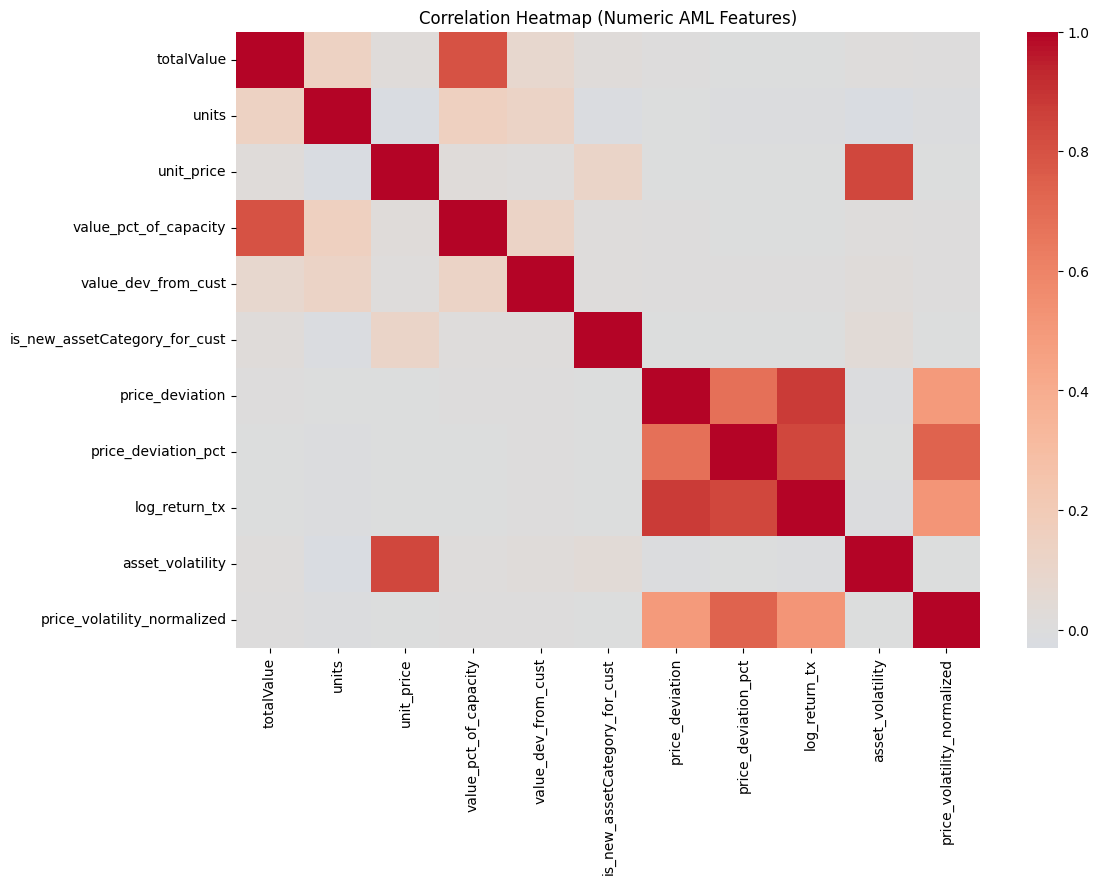


Top correlations:
price_deviation              log_return_tx                  0.878280
log_return_tx                price_deviation                0.878280
                             price_deviation_pct            0.841248
price_deviation_pct          log_return_tx                  0.841248
unit_price                   asset_volatility               0.841224
asset_volatility             unit_price                     0.841224
totalValue                   value_pct_of_capacity          0.801059
value_pct_of_capacity        totalValue                     0.801059
price_volatility_normalized  price_deviation_pct            0.737784
price_deviation_pct          price_volatility_normalized    0.737784
dtype: float64

=== Feature Variance (Higher = more expressive feature) ===
totalValue                       2.975101e+10
units                            2.422830e+08
unit_price                       7.249726e+03
asset_volatility                 1.262170e+02
value_pct_of_capacity          

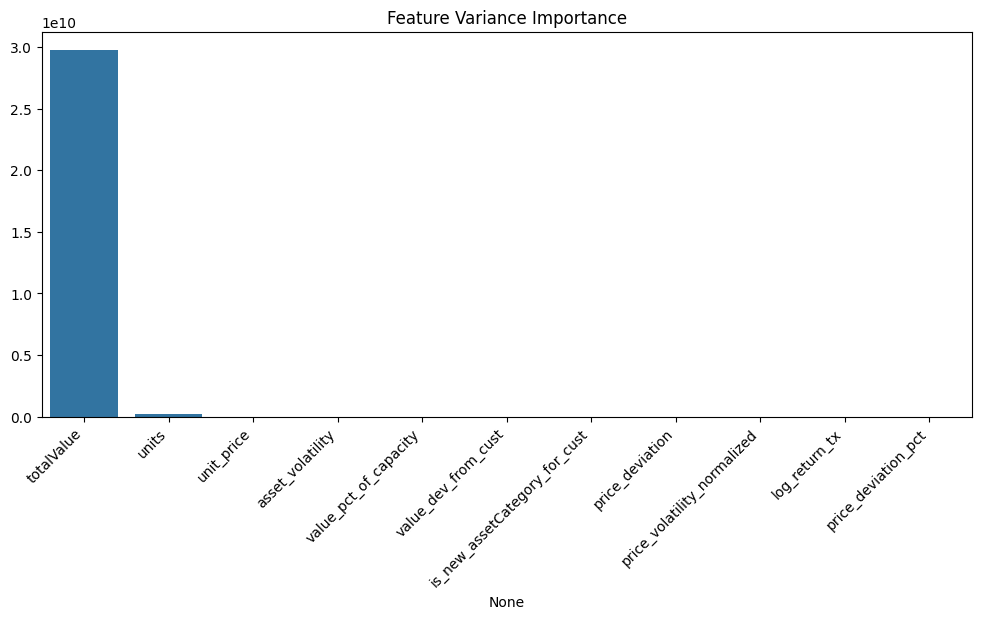

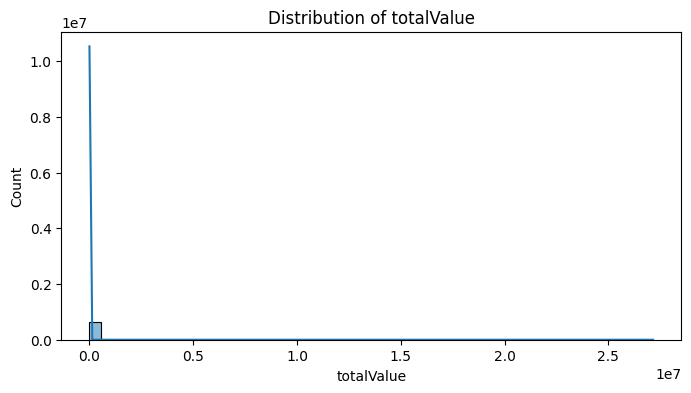

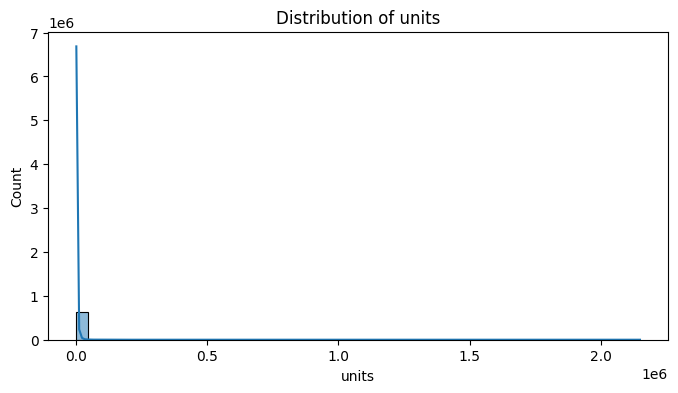

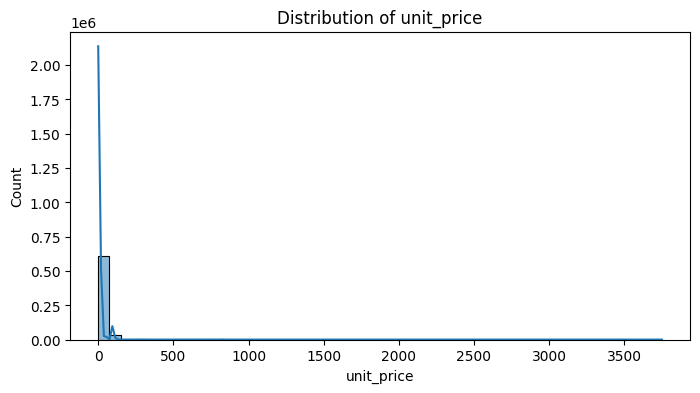

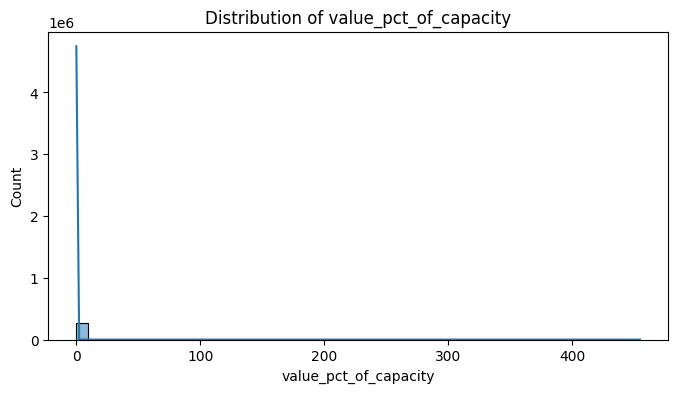

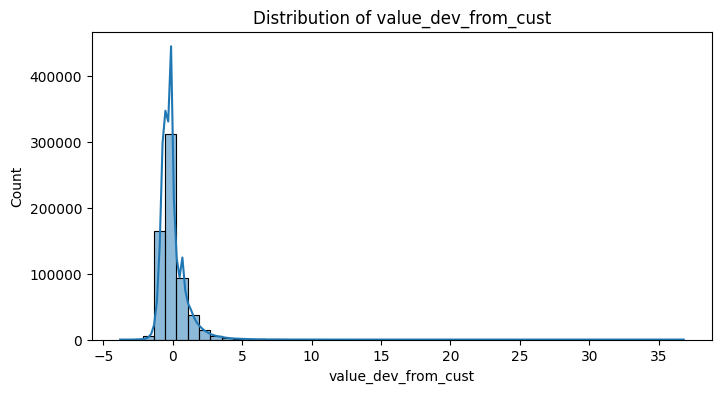

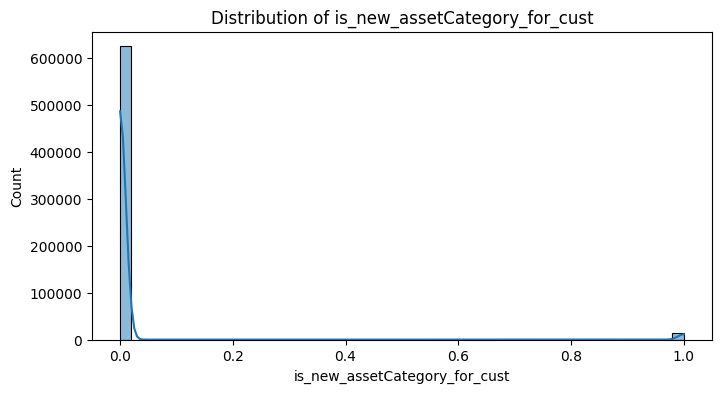

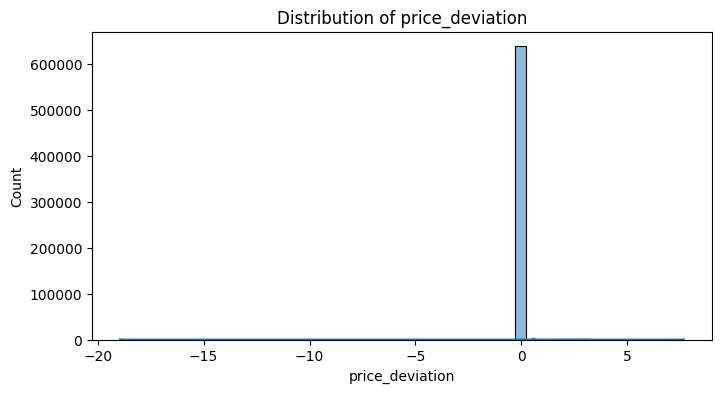

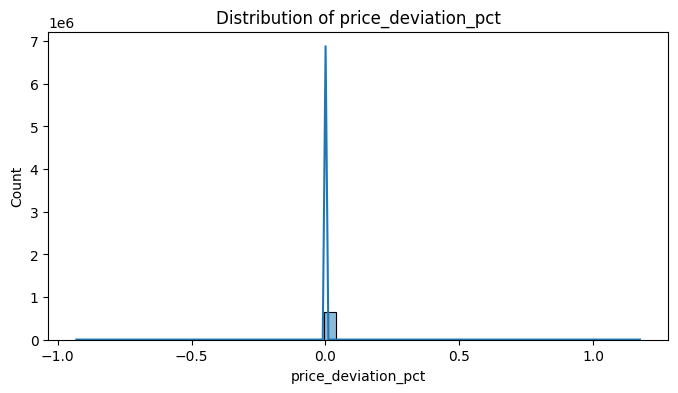

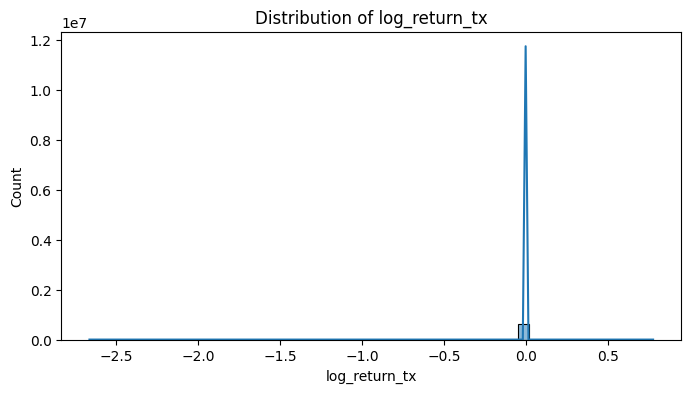

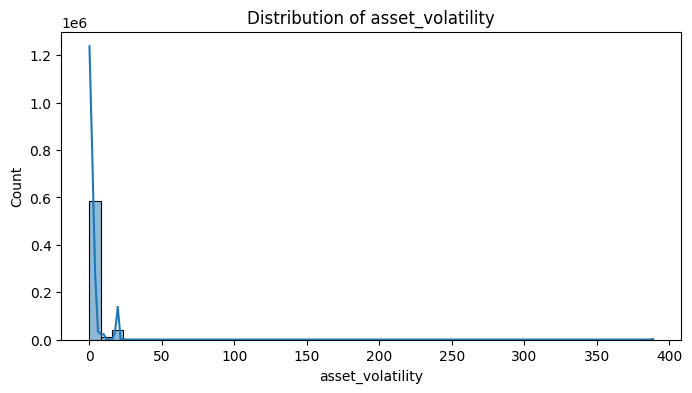

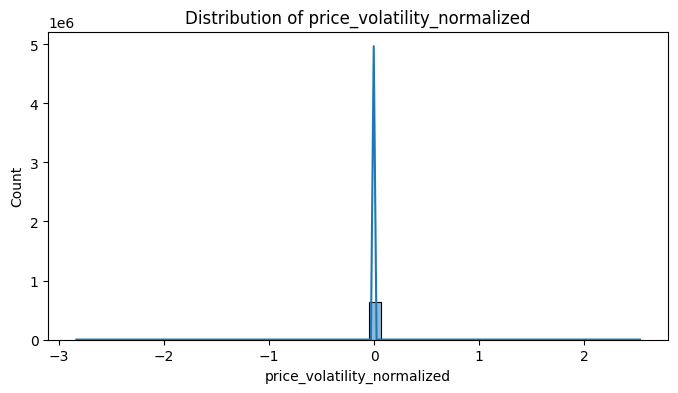

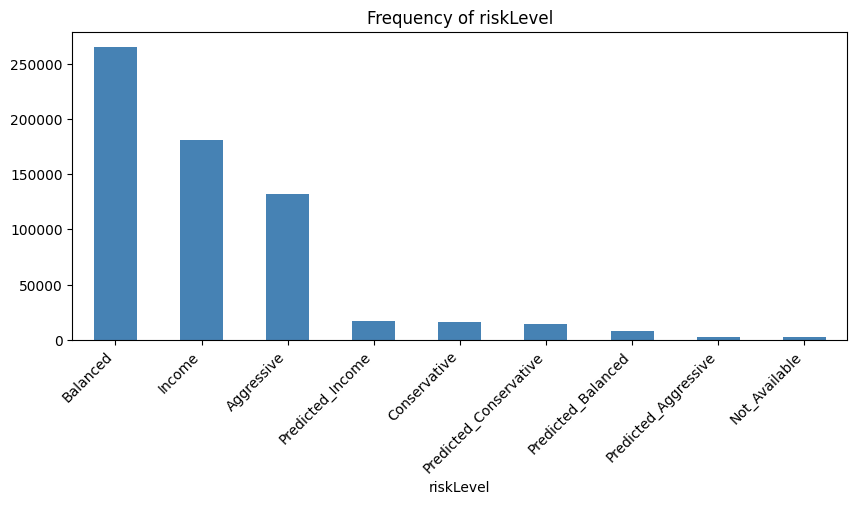

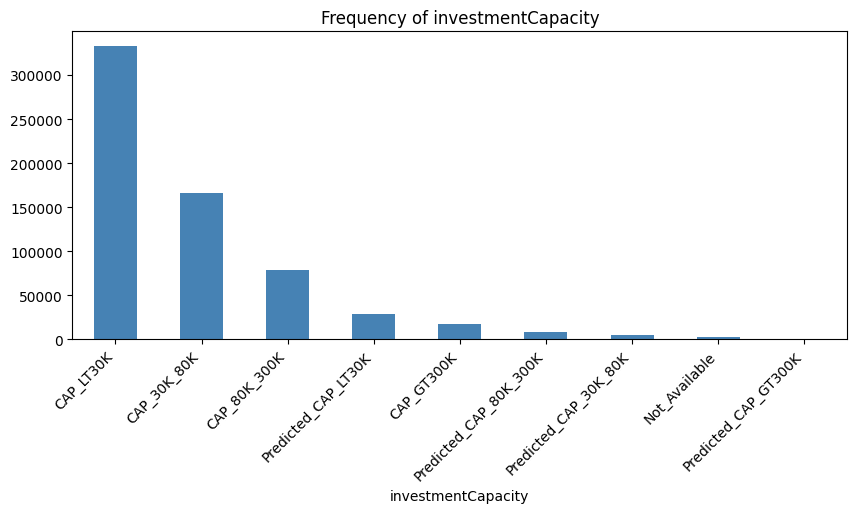

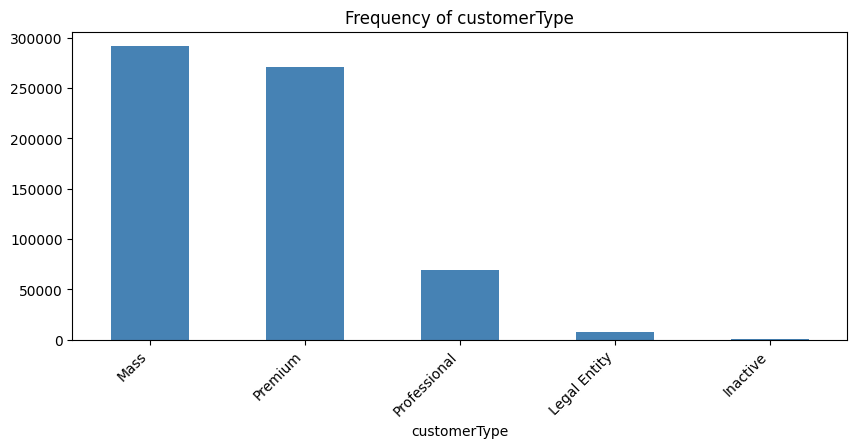

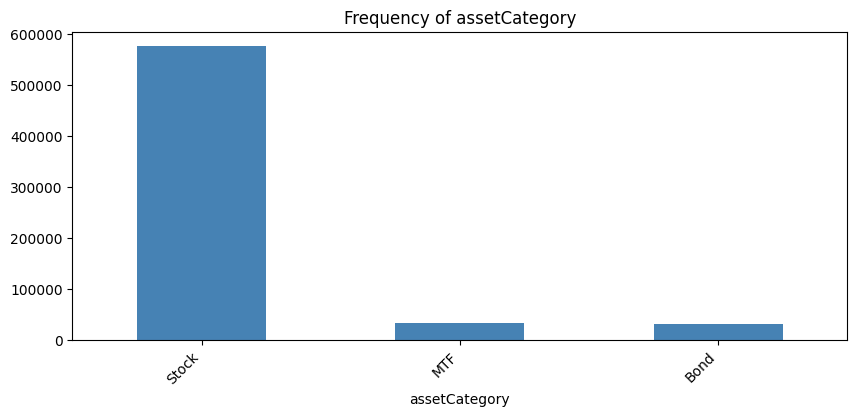

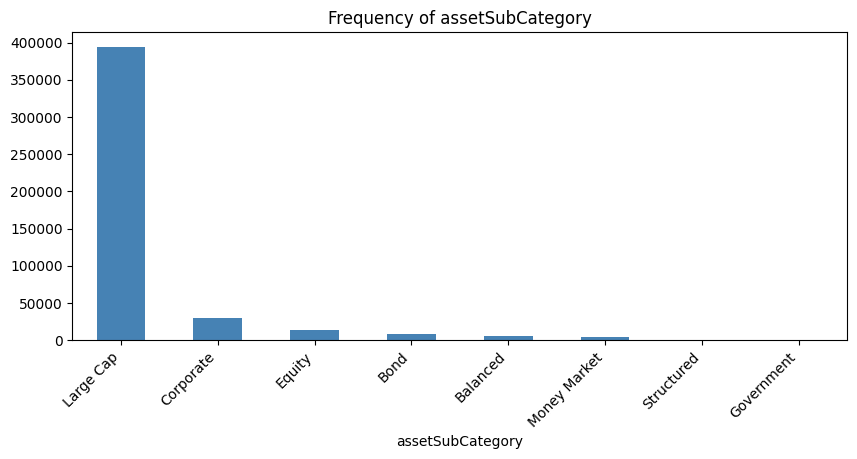

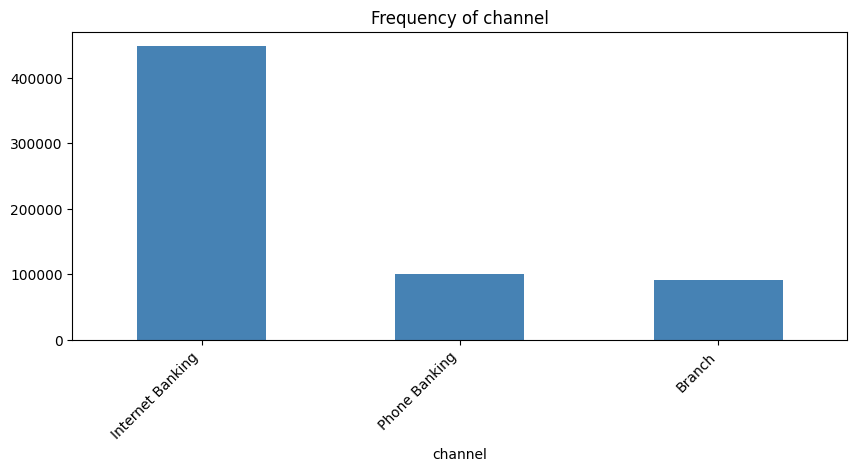

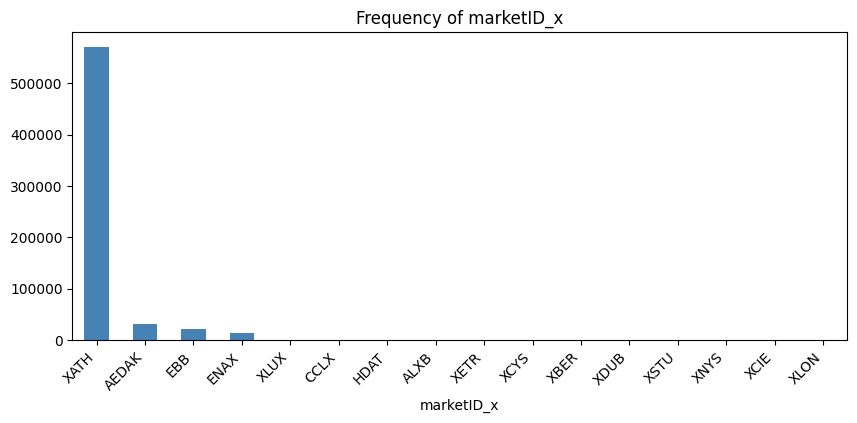

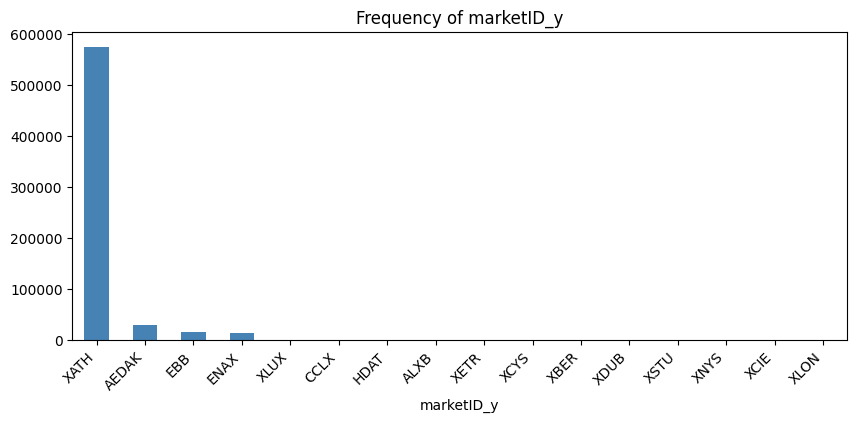


=== Outlier Count per Feature (>3σ) ===
is_new_assetCategory_for_cust    14450
units                             6541
unit_price                        1416
totalValue                         665
asset_volatility                   565
price_volatility_normalized        503
price_deviation_pct                482
log_return_tx                      374
price_deviation                    370
value_pct_of_capacity                0
value_dev_from_cust                  0
dtype: int64


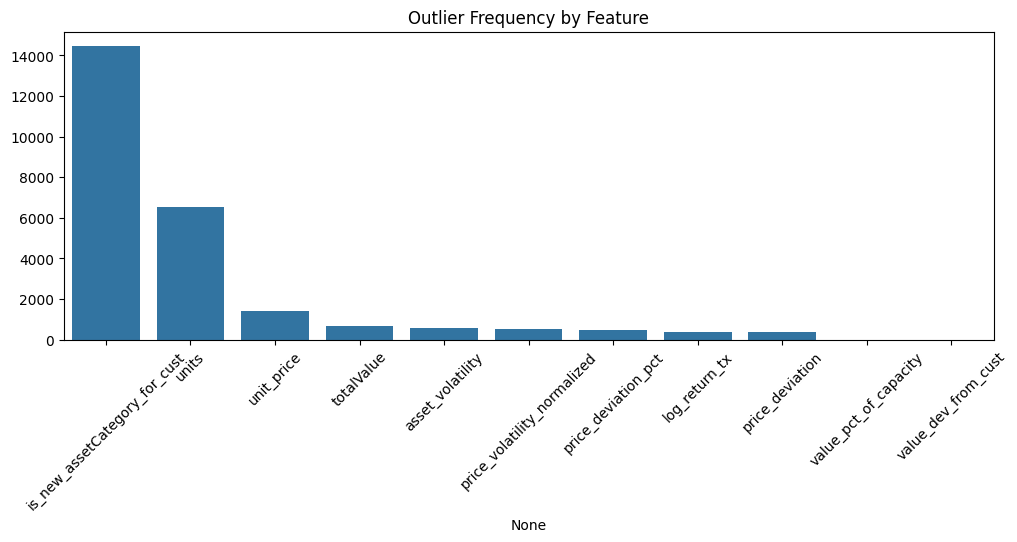


=== Mutual Information Scores (Feature Dependence Strength) ===
totalValue                       9.832684
unit_price                       4.365715
value_pct_of_capacity            3.704147
value_dev_from_cust              3.253287
units                            2.345994
asset_volatility                 1.331699
is_new_assetCategory_for_cust    0.036463
log_return_tx                    0.004136
price_deviation_pct              0.003953
price_deviation                  0.002960
price_volatility_normalized      0.002888
dtype: float64


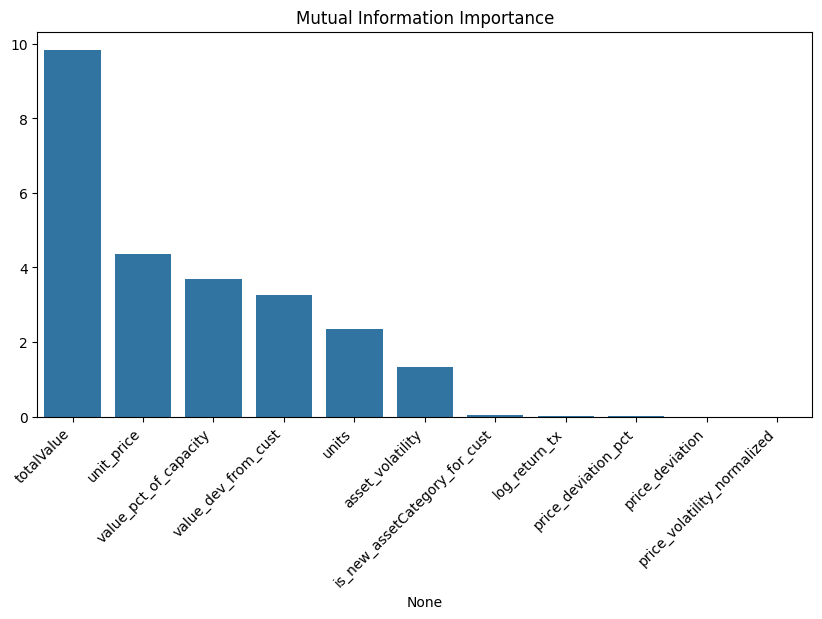

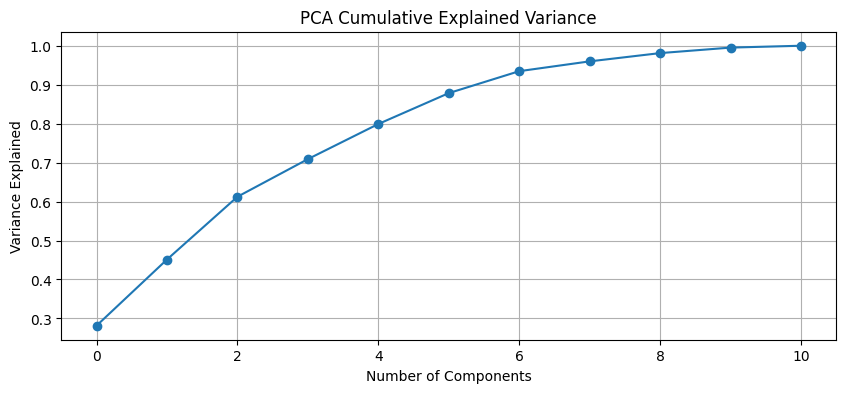


Variance explained by first 5 PCA components:
PCA1: 0.2812
PCA2: 0.1699
PCA3: 0.1611
PCA4: 0.0966
PCA5: 0.0901


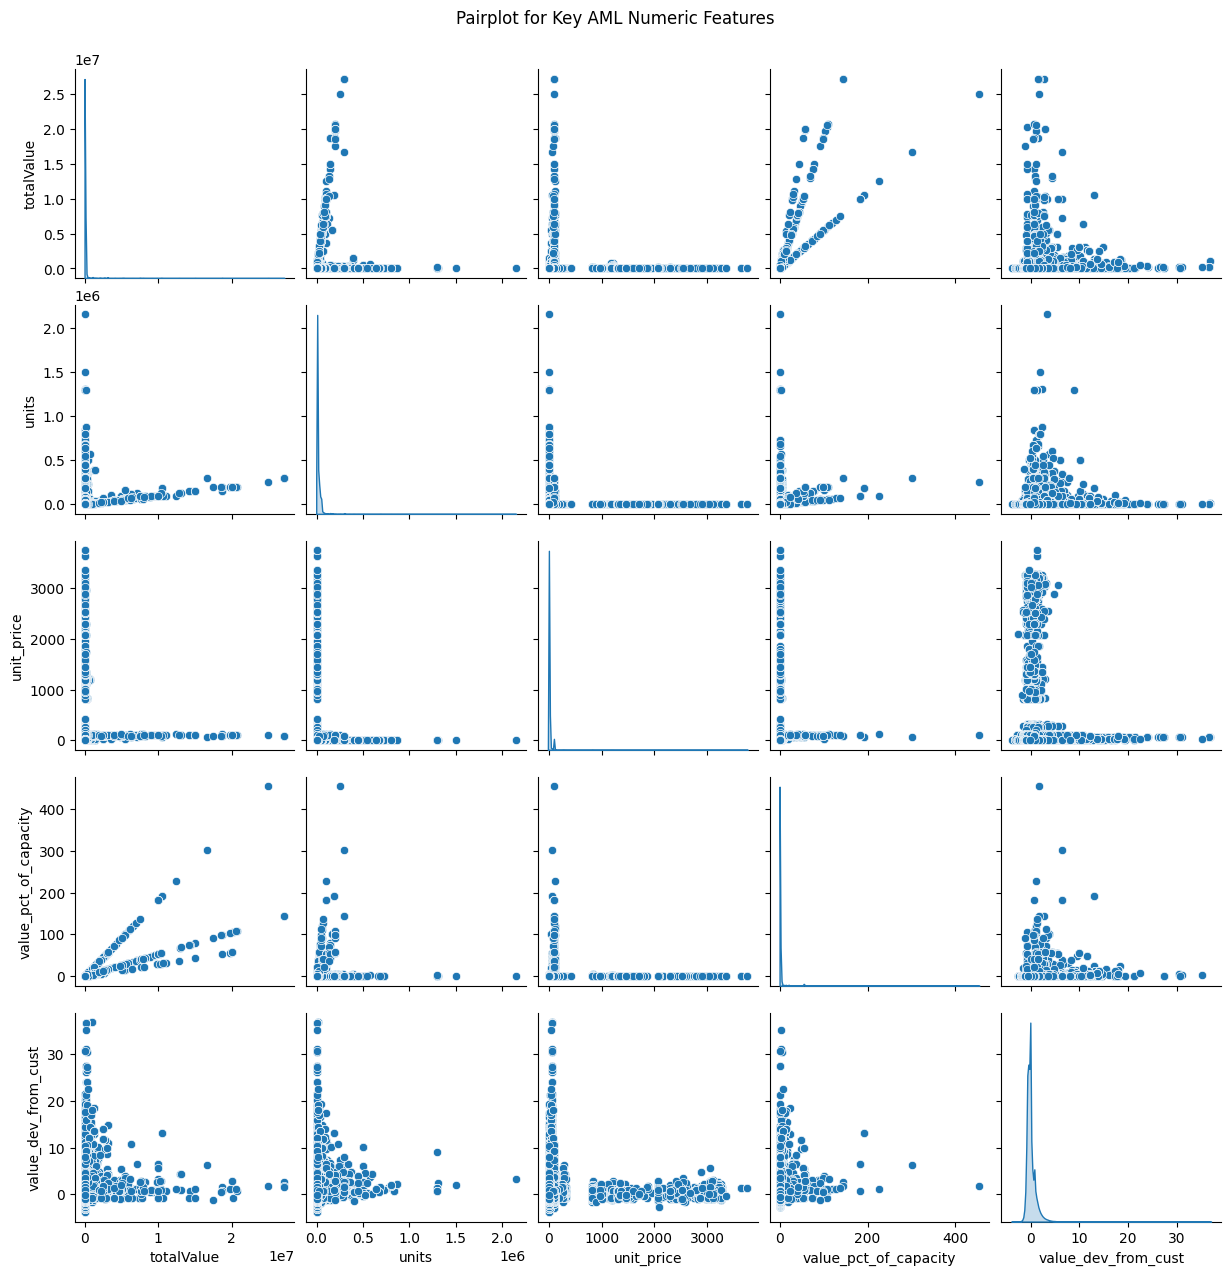

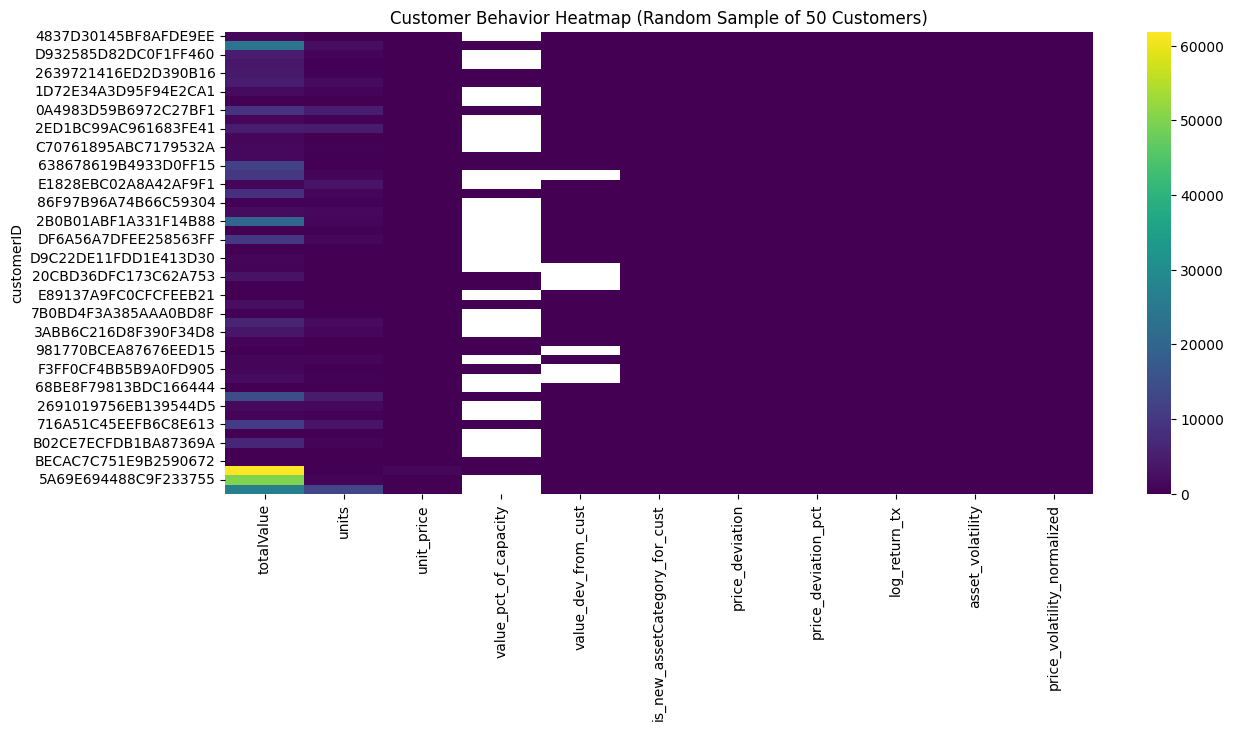


Customer behavior variance:
totalValue                       1.344123e+11
units                            5.473739e+07
unit_price                       1.792541e+04
asset_volatility                 1.907389e+02
value_pct_of_capacity            1.191864e+01
is_new_assetCategory_for_cust    9.311653e-03
price_deviation                  1.080399e-03
price_volatility_normalized      6.669126e-04
log_return_tx                    1.482948e-05
price_deviation_pct              8.616073e-06
value_dev_from_cust              7.643771e-18
dtype: float64


In [6]:
# ============================================================
# 4.EXTENDED EDA AFTER MERGING & FEATURE ENGINEERING
# ============================================================

print("\n=== DATASET SUMMARY ===")
print(df.describe(include="all"))

print("\nMissing values:")
print(df.isna().sum())

# ============================================================
# 1. NUMERIC FEATURES CORRELATION HEATMAP
# ============================================================

num_features_eda = [
    "totalValue",
    "units",
    "unit_price",
    "value_pct_of_capacity",
    "value_dev_from_cust",
    "is_new_assetCategory_for_cust",
    "price_deviation",
    "price_deviation_pct",
    "log_return_tx",
    "asset_volatility",
    "price_volatility_normalized"
]

plt.figure(figsize=(12, 8))
corr = df[num_features_eda].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric AML Features)")
plt.show()

# High absolute correlations
print("\nTop correlations:")
top_corr = corr.abs().unstack().sort_values(ascending=False)
print(top_corr[top_corr < 1].head(10))

# ============================================================
# 2. FEATURE VARIANCE IMPORTANCE
# ============================================================

variance = df[num_features_eda].var().sort_values(ascending=False)
print("\n=== Feature Variance (Higher = more expressive feature) ===")
print(variance)

plt.figure(figsize=(12, 5))
sns.barplot(x=variance.index, y=variance.values)
plt.xticks(rotation=45, ha="right")
plt.title("Feature Variance Importance")
plt.show()

# ============================================================
# 3. DISTRIBUTION PLOTS FOR KEY FEATURES
# ============================================================

for col in num_features_eda:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

# ============================================================
# 4. CATEGORICAL FEATURE FREQUENCIES
# ============================================================

cat_features_eda = ["riskLevel", "investmentCapacity", "customerType",
                    "assetCategory", "assetSubCategory", "channel", "marketID_x","marketID_y"]

for col in cat_features_eda:
    plt.figure(figsize=(10, 4))
    df[col].value_counts().plot(kind="bar", color="steelblue")
    plt.title(f"Frequency of {col}")
    plt.xticks(rotation=45, ha="right")
    plt.show()

# ============================================================
# 5. OUTLIER ANALYSIS (Z-SCORE BASED)
# ============================================================

from scipy.stats import zscore
z_scores = df[num_features_eda].apply(zscore)

outlier_counts = (np.abs(z_scores) > 3).sum().sort_values(ascending=False)
print("\n=== Outlier Count per Feature (>3σ) ===")
print(outlier_counts)

plt.figure(figsize=(12, 4))
sns.barplot(x=outlier_counts.index, y=outlier_counts.values)
plt.xticks(rotation=45)
plt.title("Outlier Frequency by Feature")
plt.show()

# ============================================================
# 6. MUTUAL INFORMATION (MI) — Feature Importance for Anomaly-Relevant Signals
# ============================================================

from sklearn.feature_selection import mutual_info_regression

# Use totalValue as a reference target to measure importance
mi_scores = mutual_info_regression(df[num_features_eda].fillna(0),
                                   df["totalValue"].fillna(0))
mi_series = pd.Series(mi_scores, index=num_features_eda).sort_values(ascending=False)

print("\n=== Mutual Information Scores (Feature Dependence Strength) ===")
print(mi_series)

plt.figure(figsize=(10, 5))
sns.barplot(x=mi_series.index, y=mi_series.values)
plt.xticks(rotation=45, ha="right")
plt.title("Mutual Information Importance")
plt.show()

# ============================================================
# 7. PCA — Understanding Dimensional Structure
# ============================================================

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_scaled = sc.fit_transform(df[num_features_eda].fillna(0))

pca = PCA()
pca.fit(X_scaled)

explained = pca.explained_variance_ratio_

plt.figure(figsize=(10,4))
plt.plot(np.cumsum(explained), marker='o')
plt.title("PCA Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Variance Explained")
plt.grid(True)
plt.show()

print("\nVariance explained by first 5 PCA components:")
for i in range(5):
    print(f"PCA{i+1}: {explained[i]:.4f}")

# ============================================================
# 8. SCATTERPLOT MATRIX (PAIRPLOT)
# ============================================================

sns.pairplot(df[num_features_eda[:5]], diag_kind="kde")
plt.suptitle("Pairplot for Key AML Numeric Features", y=1.02)
plt.show()

# ============================================================
# 9. CUSTOMER BEHAVIOR PROFILE ANALYSIS
# ============================================================

cust_summary = df.groupby("customerID")[num_features_eda].mean()

plt.figure(figsize=(14, 6))
sns.heatmap(cust_summary.sample(50), cmap="viridis")
plt.title("Customer Behavior Heatmap (Random Sample of 50 Customers)")
plt.show()

print("\nCustomer behavior variance:")
print(cust_summary.var().sort_values(ascending=False))



Applying EDA-driven feature decisions...

Log transformation suitability:
                       feature           min           max   skewness  \
0                   totalValue  2.831069e-16  2.715912e+07  80.412912   
1                        units  5.898060e-17  2.150000e+06  31.112223   
2                   unit_price  1.000000e-02  3.749990e+03  28.093184   
3             asset_volatility  3.255766e-03  3.889518e+02  28.103404   
4        value_pct_of_capacity  2.243819e-20  4.545455e+02  83.293598   
5          price_deviation_pct -9.303045e-01  1.175438e+00  11.557608   
6  price_volatility_normalized -2.830784e+00  2.528535e+00  -9.600152   

   non_negative  log_transform                       reason  
0          True           True  Non-negative & right-skewed  
1          True           True  Non-negative & right-skewed  
2          True           True  Non-negative & right-skewed  
3          True           True  Non-negative & right-skewed  
4          True           True

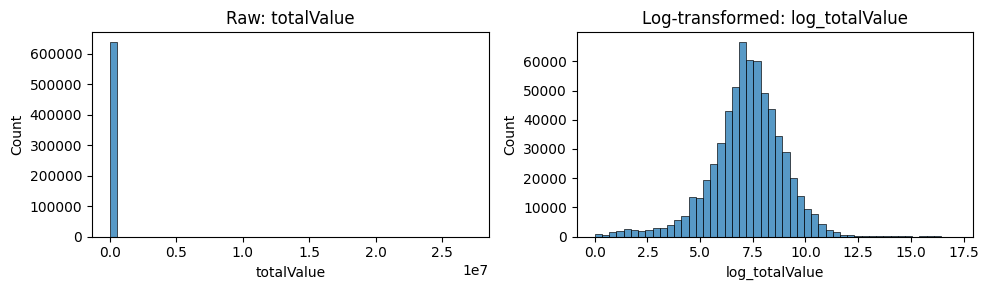

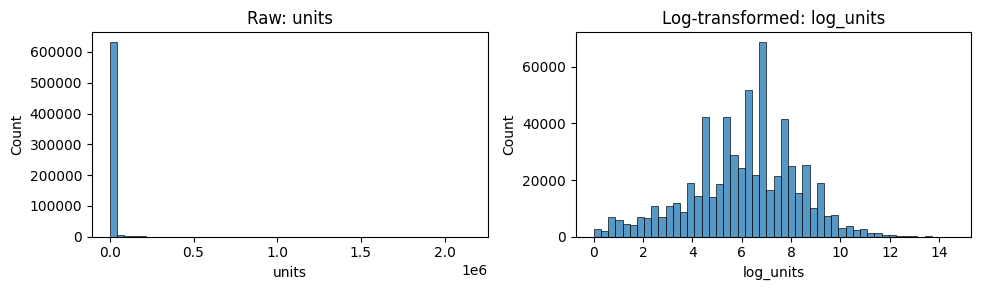

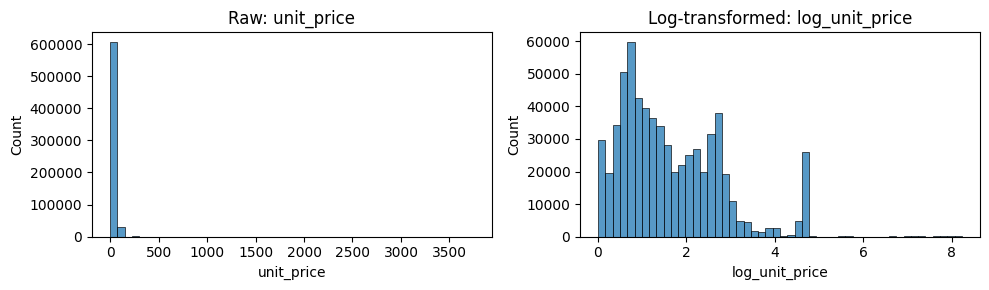

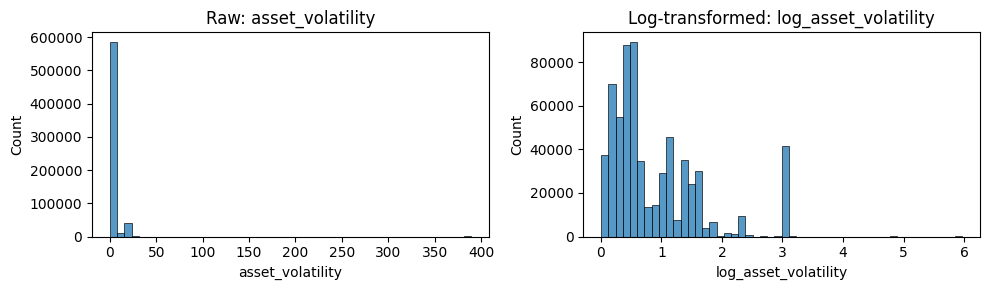

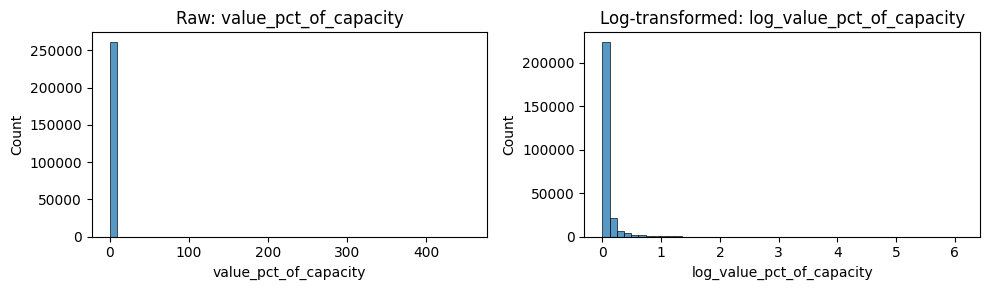

         feature_1        feature_2  correlation
7  price_deviation    log_return_tx      0.87828
9    log_return_tx  price_deviation      0.87828
Features marked for removal due to redundancy:
{'price_deviation'}


,lower,upper,num_clipped
value_dev_from_cust,-1.317730e+00,3.415850e+00,12760.0
price_deviation_pct,-1.538051e-16,1.769278e-16,12768.0
price_volatility_normalized,-8.654388e-16,1.097593e-15,11991.0
value_pct_of_capacity,1.178182e-04,9.571636e-01,5203.0


In [7]:
# ============================================================
# 5 DECISION & FEATURE ADJUSTMENT (EDA-DRIVEN)
# ============================================================

print("\nApplying EDA-driven feature decisions...")

# ------------------------------------------------------------
# 1. LOG-TRANSFORM HEAVY-TAILED FEATURES
# (Observed from distribution plots)
# ------------------------------------------------------------

# ============================================================
# LOG TRANSFORMATION SUITABILITY CHECK
# ============================================================

from scipy.stats import skew

# Candidate numeric features to evaluate
log_check_features = [
    "totalValue",
    "units",
    "unit_price",
    "asset_volatility",
    "value_pct_of_capacity",
    "price_deviation_pct",
    "price_volatility_normalized"
]

log_decision_table = []

for col in log_check_features:
    if col not in df.columns:
        continue

    col_data = df[col].dropna()

    decision = {
        "feature": col,
        "min": col_data.min(),
        "max": col_data.max(),
        "skewness": skew(col_data),
        "non_negative": col_data.min() >= 0,
        "log_transform": False,
        "reason": ""
    }

    # Decision rules
    if decision["non_negative"] and decision["skewness"] > 1:
        decision["log_transform"] = True
        decision["reason"] = "Non-negative & right-skewed"
    elif not decision["non_negative"]:
        decision["reason"] = "Contains negative values"
    else:
        decision["reason"] = "Not sufficiently skewed"

    log_decision_table.append(decision)

log_decision_df = pd.DataFrame(log_decision_table)
print("\nLog transformation suitability:")
print(log_decision_df)
# ============================================================
# APPLY LOG TRANSFORMATIONS (EDA-APPROVED)
# ============================================================

log_features_applied = []

for _, row in log_decision_df.iterrows():
    if row["log_transform"]:
        col = row["feature"]
        new_col = f"log_{col}"
        df[new_col] = np.log1p(df[col])
        log_features_applied.append(new_col)

print("\nLog-transformed features applied:")
print(log_features_applied)

# ============================================================
# OPTIONAL: BEFORE / AFTER DISTRIBUTION CHECK
# ============================================================

for col in log_features_applied:
    raw_col = col.replace("log_", "")

    plt.figure(figsize=(10, 3))

    plt.subplot(1, 2, 1)
    sns.histplot(df[raw_col], bins=50)
    plt.title(f"Raw: {raw_col}")

    plt.subplot(1, 2, 2)
    sns.histplot(df[col], bins=50)
    plt.title(f"Log-transformed: {col}")

    plt.tight_layout()
    plt.show()

numeric_features = [
    col if not col.startswith("log_") else col
    for col in [
        "log_totalValue",
        "log_units",
        "value_pct_of_capacity",
        "value_dev_from_cust",
        "is_new_assetCategory_for_cust",
        "price_deviation_pct",
        "log_return_tx",
        "log_asset_volatility",
        "log_price_volatility_normalized"
    ]
    if col in df.columns
]
# ------------------------------------------------------------
# 2. REMOVE REDUNDANT / HIGHLY CORRELATED FEATURES
# (Observed from correlation heatmap)
# ------------------------------------------------------------

high_corr_pairs = (corr.abs().where(lambda x: x > 0.85)
        .stack().reset_index())

high_corr_pairs.columns = ["feature_1", "feature_2", "correlation"]
high_corr_pairs = high_corr_pairs[high_corr_pairs["feature_1"] != high_corr_pairs["feature_2"]]

print(high_corr_pairs)


#feature importance
weights = {
    "behavioral": 3,
    "scale_invariant": 2,
    "normalized": 2,
    "interpretable": 1,}
feature_meta = {
    "log_totalValue": {
        "behavioral": False,
        "scale_invariant": False,
        "normalized": False,
        "interpretable": True,
    },
    "price_deviation_pct": {
        "behavioral": True,
        "scale_invariant": True,
        "normalized": True,
        "interpretable": True,
    },
    "price_volatility_normalized": {
        "behavioral": True,
        "scale_invariant": True,
        "normalized": True,
        "interpretable": True,
    },
    "price_deviation": {
        "behavioral": False,
        "scale_invariant": False,
        "normalized": False,
        "interpretable": True,
    },
    "value_dev_from_cust": {
        "behavioral": True,
        "scale_invariant": True,
        "normalized": True,
        "interpretable": True,
    },

    "log_return_tx": {
        "behavioral": True,
        "scale_invariant": True,
        "normalized": True,
        "interpretable": True,
    },
}

feature_preference = {}

for feat, meta in feature_meta.items():
  score = sum(weights[k] * int(meta[k])
        for k in weights)
  feature_preference[feat] = score

feature_preference

# Drop features

to_drop = set()

for _, row in high_corr_pairs.iterrows():
    f1, f2 = row["feature_1"], row["feature_2"]

    if f1 in feature_preference and f2 in feature_preference:
        drop = f1 if feature_preference[f1] < feature_preference[f2] else f2
        to_drop.add(drop)

print("Features marked for removal due to redundancy:")
print(to_drop)
df.drop(columns=list(to_drop), inplace=True, errors="ignore")

## explanation:
#price_deviation was highly correlated with log_return_tx. We retained the relative, scale-invariant log-return feature and removed the absolute deviation to avoid redundancy and improve model stability.”


##3. Clip extreme outliers
clip_features = [
    "value_dev_from_cust",          # Z-score-like, can explode
    "price_deviation_pct",          # Percent deviation can be extreme
    "price_volatility_normalized",  # Ratio-based, unstable tails
    "value_pct_of_capacity",        # Can be >> 1 for risky trades
]

clip_report = {}

for col in clip_features:
    q_low = df[col].quantile(0.01)
    q_high = df[col].quantile(0.99)
    clip_report[col] = {
        "lower": q_low,
        "upper": q_high,
        "num_clipped": ((df[col] < q_low) | (df[col] > q_high)).sum()
    }
    df[col] = df[col].clip(q_low, q_high)

pd.DataFrame(clip_report).T



Numeric features used: ['log_totalValue', 'log_units', 'value_dev_from_cust', 'value_pct_of_capacity', 'is_new_assetCategory_for_cust', 'price_deviation_pct', 'log_return_tx', 'log_asset_volatility']
Categorical features used: ['riskLevel', 'investmentCapacity', 'customerType', 'assetCategory', 'assetSubCategory', 'channel']
sklearn version: 1.6.1
Feature matrix shape: (639535, 46)
Number of features: 46
Isolation Forest anomalies: 6395
Epoch 1/25
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0753 - val_loss: 0.0124
Epoch 2/25
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0129 - val_loss: 0.0083
Epoch 3/25
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0095 - val_loss: 0.0072
Epoch 4/25
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0073 - val_loss: 0.0065
Epoch 5/25
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0068 - val_loss: 0.0059
Epoch 6/25
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0059 - val_loss: 0.0056
Epoch 7/25
2249/2249 ━━━━━━━━━

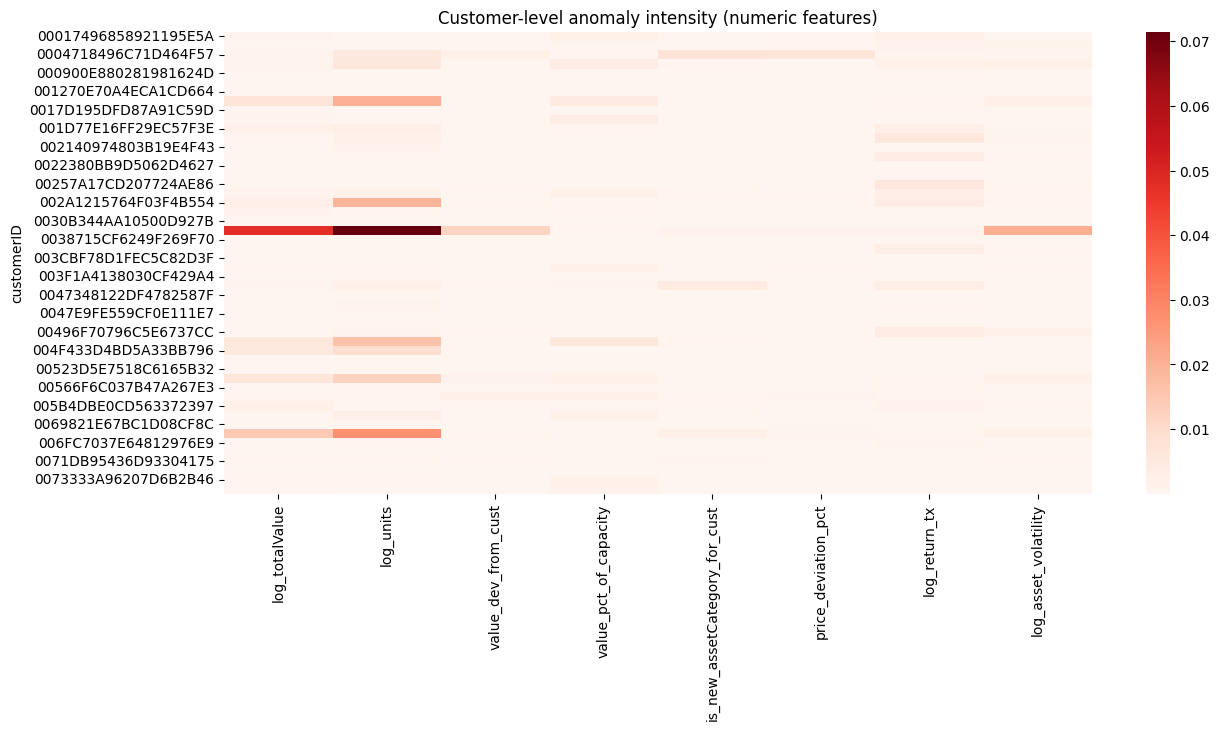

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Saved artifacts to: /content/drive/MyDrive/ae_aml_artifacts


In [9]:
# ============================================================
# 6. DEFINE MODELING FEATURES (FINAL) + BUILD df_model
# ============================================================

# (If you already defined these above, this will just re-use them safely.)
numeric_features = [
    "log_totalValue",
    "log_units",
    "value_dev_from_cust",
    "value_pct_of_capacity",
    "is_new_assetCategory_for_cust",
    "price_deviation_pct",
    "log_return_tx",
    "log_asset_volatility",
    "log_price_volatility_normalized",
]
numeric_features = [c for c in numeric_features if c in df.columns]

categorical_features = [
    "riskLevel",
    "investmentCapacity",
    "customerType",
    "assetCategory",
    "assetSubCategory",
    "channel",
    "marketID",
]
categorical_features = [c for c in categorical_features if c in df.columns]

print("Numeric features used:", numeric_features)
print("Categorical features used:", categorical_features)

df_model = df[numeric_features + categorical_features].copy()
df_model[numeric_features] = df_model[numeric_features].replace([np.inf, -np.inf], np.nan).fillna(0)
df_model[categorical_features] = df_model[categorical_features].fillna("Unknown")

# ============================================================
# 7. PREPROCESSING: SCALING + ONE-HOT ENCODING (COLAB SAFE)
# ============================================================

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import sklearn

print("sklearn version:", sklearn.__version__)

cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", cat_encoder, categorical_features),
    ]
)

X = preprocess.fit_transform(df_model)

# Feature names (numeric + one-hot categorical)
cat_names = list(
    preprocess.named_transformers_["cat"]
    .get_feature_names_out(categorical_features)
)
feature_names = numeric_features + cat_names

print("Feature matrix shape:", X.shape)
print("Number of features:", len(feature_names))

# ============================================================
# 7B. ISOLATION FOREST (PARALLEL ANOMALY SIGNAL)
# ============================================================

from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(
    n_estimators=300,
    contamination=0.01,    # ~1% anomalies (align with AE)
    random_state=42,
    n_jobs=-1
)

iso_forest.fit(X)

# Isolation Forest anomaly score
# (higher = more anomalous)
df["iso_score"] = -iso_forest.decision_function(X)

# Binary anomaly flag
df["is_iso_anomaly"] = iso_forest.predict(X) == -1

print("Isolation Forest anomalies:", df["is_iso_anomaly"].sum())


# ============================================================
# 8. TRAIN AUTOENCODER (UNSUPERVISED)
# ============================================================

import tensorflow as tf
from tensorflow.keras import layers, models

tf.random.set_seed(42)

input_dim = X.shape[1]

inputs = tf.keras.Input(shape=(input_dim,))
x = layers.Dense(64, activation="relu")(inputs)
x = layers.Dense(32, activation="relu")(x)
latent = layers.Dense(16, activation="relu")(x)
x = layers.Dense(32, activation="relu")(latent)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(input_dim, activation="linear")(x)

autoencoder = models.Model(inputs, outputs)
autoencoder.compile(optimizer="adam", loss="mse")

history = autoencoder.fit(
    X, X,
    epochs=25,
    batch_size=256,
    validation_split=0.1,
    verbose=1
)

# ============================================================
# 9. RECONSTRUCTION & ANOMALY SCORING
# ============================================================

X_pred = autoencoder.predict(X, verbose=0)
recon_error = np.mean((X - X_pred) ** 2, axis=1)

df["recon_error"] = recon_error

threshold = np.percentile(recon_error, 99)  # top 1% anomalies
df["is_anomaly"] = df["recon_error"] > threshold

print("Threshold (99th percentile):", threshold)
print("Number of anomalies:", int(df["is_anomaly"].sum()))

anom_indices = df[df["is_anomaly"]].index

# ============================================================
# 9B. COMBINED ANOMALY SCORING (AE + IF)
# ============================================================

# Normalize scores
df["ae_score_norm"] = (
    (df["recon_error"] - df["recon_error"].min()) /
    (df["recon_error"].max() - df["recon_error"].min() + 1e-6)
)

df["iso_score_norm"] = (
    (df["iso_score"] - df["iso_score"].min()) /
    (df["iso_score"].max() - df["iso_score"].min() + 1e-6)
)

# Combined risk score
df["combined_score"] = (
    0.6 * df["ae_score_norm"] +
    0.4 * df["iso_score_norm"]
)

# Final combined anomaly flag
combined_threshold = df["combined_score"].quantile(0.99)
df["is_combined_anomaly"] = df["combined_score"] > combined_threshold

print("Combined AE + IF anomalies:", df["is_combined_anomaly"].sum())

##9d - add-Investigator-friendly classification

df["anomaly_source"] = np.select(
    [
        df["is_anomaly"] & df["is_iso_anomaly"],
        df["is_anomaly"],
        df["is_iso_anomaly"]
    ],
    [
        "AE + IF (High Confidence)",
        "AE only (Behavioral)",
        "IF only (Extreme Outlier)"
    ],
    default="Normal"
)
print("\nInvestigator-friendly anomaly breakdown:")
print(df["anomaly_source"].value_counts())


# ============================================================
# 10. EXPLAINABILITY (LOCAL + GLOBAL + CUSTOMER HEATMAP)
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# 10.1 Feature-level reconstruction errors
error_matrix = (X - X_pred) ** 2
error_df = pd.DataFrame(error_matrix, columns=feature_names)
error_df["is_anomaly"] = df["is_anomaly"].values
error_df["customerID"] = df["customerID"].values

def explain_top_features(index, k=5):
    """
    Top-k features contributing to reconstruction error for a single row.
    """
    row_err = error_matrix[index]
    return pd.Series(row_err, index=feature_names).sort_values(ascending=False).head(k)

# 10.2 AML-friendly mapping (transform-aware)
EXPLANATION_MAP = {
    "log_totalValue": "Unusually large transaction value for this context",
    "log_units": "Unusual traded quantity",
    "value_pct_of_capacity": "Transaction unusually large relative to customer's capacity",
    "value_dev_from_cust": "Transaction deviates sharply from customer's typical behavior",
    "is_new_assetCategory_for_cust": "Customer is trading a new/unusual asset category",
    "price_deviation_pct": "Large percentage deviation from market closing price",
    "log_return_tx": "Transaction executed far from prevailing market price",
    "log_asset_volatility": "Asset has high volatility for this customer's trades",
    "log_price_volatility_normalized": "Transaction price far from expected range given asset volatility",
}

def explain_categorical_feature(feat):
    """
    Convert one-hot feature names (e.g., riskLevel_High) into readable text.
    """
    if "_" not in feat:
        return f"Unusual pattern in {feat}"
    base, category = feat.split("_", 1)

    mapping = {
        "riskLevel": f"Transaction associated with unusual risk level: {category}",
        "investmentCapacity": f"Customer investment capacity category: {category}",
        "customerType": f"Customer type unusual: {category}",
        "assetCategory": f"Unusual asset category: {category}",
        "assetSubCategory": f"Unusual asset sub-category: {category}",
        "channel": f"Transaction executed via unusual channel: {category}",
        "marketID": f"Transaction occurred in unusual market: {category}",
    }
    return mapping.get(base, f"Unusual categorical pattern: {feat}")

def explain_anomaly(index, k=5):
    """
    Returns (feature_errors, human_readable_messages) for a given anomaly index.
    """
    s = explain_top_features(index, k=k)
    messages = []
    for feat in s.index:
        if feat in EXPLANATION_MAP:
            messages.append(EXPLANATION_MAP[feat])
        elif "_" in feat:
            messages.append(explain_categorical_feature(feat))
        else:
            messages.append(f"Unusual pattern in {feat}")
    return s, messages

# 10.3 Example local explanation
if len(anom_indices) > 0:
    example_idx = anom_indices[0]
    scores, msgs = explain_anomaly(example_idx, k=5)
    print("\nExample anomaly index:", example_idx)
    print("\nTop contributing features:\n", scores)
    print("\nHuman-friendly explanations:")
    for m in msgs:
        print("-", m)

# 10.4 Global anomaly drivers
feature_counter = Counter()
for idx in anom_indices:
    top3 = explain_top_features(idx, k=3)
    feature_counter.update(top3.index.tolist())

print("\nMost frequent anomaly-driving features:")
for feat, count in feature_counter.most_common(15):
    print(f"{feat}: {count}")

# 10.5 Customer-level anomaly summary
cust_anom = df.groupby("customerID")["is_anomaly"].agg(
    num_anomalies="sum",
    anom_rate="mean"
).sort_values("num_anomalies", ascending=False)

print("\nTop customers by number of anomalies:")
print(cust_anom.head(10))

# 10.6 Customer-level numeric-feature heatmap (mean squared error)
cust_feature_error = error_df.groupby("customerID")[numeric_features].mean()

plt.figure(figsize=(14, 6))
sns.heatmap(cust_feature_error.head(50), cmap="Reds")
plt.title("Customer-level anomaly intensity (numeric features)")
plt.show()

# ============================================================
# 11. SAVE ARTIFACTS TO GOOGLE DRIVE
# ============================================================

from google.colab import drive
drive.mount("/content/drive")

SAVE_DIR = "/content/drive/MyDrive/ae_aml_artifacts"
import os
os.makedirs(SAVE_DIR, exist_ok=True)

# Save model
autoencoder.save(f"{SAVE_DIR}/autoencoder_model.keras")

# Save preprocess
with open(f"{SAVE_DIR}/preprocess.pkl", "wb") as f:
    pickle.dump(preprocess, f)

# Save feature lists
with open(f"{SAVE_DIR}/feature_names.json", "w") as f:
    json.dump(feature_names, f)

with open(f"{SAVE_DIR}/numeric_features.json", "w") as f:
    json.dump(numeric_features, f)

with open(f"{SAVE_DIR}/categorical_features.json", "w") as f:
    json.dump(categorical_features, f)

print(f"\nSaved artifacts to: {SAVE_DIR}")
